# RQ3. Multidimensional motif discovery (RQ3)

We conduct a guided multidimensional motif search on the multivariate residual series derived from the São Domingos de Benfica (Estrada Luz $|$ Oeste) TAZ.


In [12]:
import math
import os
import logging

import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL, STL

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)
logging.basicConfig(level=logging.INFO)

In [13]:
# read csv
hourly_taz_data = pd.read_csv(
    "../data/populationdensity/hourly_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in hourly_taz_data["taz_id"].unique():
    taz_name = hourly_taz_data[hourly_taz_data["taz_id"] == taz_id]["taz_name"].values[
        0
    ]
    taz_id_name[taz_id] = taz_name

hourly_taz_data = hourly_taz_data[hourly_taz_data["taz_name"] != "Beato (Picheleira)"]
hourly_taz_data = hourly_taz_data[
    hourly_taz_data["taz_name"] != "Alcântara (Ribeirinha - Belém)"
]
hourly_taz_data

,taz_id,taz_name,one_time,sum_terminals,sum_roaming_terminals,sum_terminals_with_active_data,sum_roaming_terminals_with_active_data,sum_phonecalls,sum_ended_phonecalls,avg_upstream_bandwidth,avg_downstream_bandwidth,min_avg_downstream_bandwidth,min_avg_upstream_bandwidth,max_upstream_bandwidth,max_downstream_bandwidth,sum_sum_terminals_sharing,wkt_taz
0,69,Areeiro (Alto Pina),2021-11-26 09:00:00,61599.0,1131.0,58113.0,1107.0,2896.0,574.0,7524.772105,101178.976512,104.328000,105.621997,39330404.0,135947840.0,0.00,POLYGON ((-9.131441060130475 38.74471703960398...
1,70,Arroios (Estefânia),2021-11-26 09:00:00,145078.0,4477.0,138532.0,4351.0,5149.0,1178.0,7678.938176,53412.218959,2752.320035,14550.430893,63988960.0,405100896.0,12.43,POLYGON ((-9.144729944918017 38.73514419538672...
2,71,Arroios (Arroios | Norte),2021-11-26 09:00:00,31194.0,945.0,29608.0,920.0,1284.0,420.0,5017.655536,58454.086946,943.014966,842.953344,3146271.0,142608816.0,0.00,POLYGON ((-9.136504202275457 38.73689574768296...
3,53,Alvalade (Campo Grande),2021-11-26 09:00:00,51055.0,864.0,48474.0,849.0,1520.0,474.0,8951.088582,70079.739010,2236.359946,17768.382601,33589812.0,96555216.0,0.00,"POLYGON ((-9.15660999782037 38.7593274576093, ..."
4,40,Lumiar (Telheiras | Oeste),2021-11-26 09:00:00,40523.0,255.0,37014.0,252.0,2314.0,382.0,3442.786203,32570.243025,1.238571,0.000000,16425652.0,168218912.0,0.00,"POLYGON ((-9.17712280774748 38.76422000124379,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175218,16,Estrela (Estrela),2021-11-26 09:00:00,199615.0,6739.0,190222.0,6497.0,7990.0,1839.0,10347.174511,75677.619332,573.914546,628.886265,67788656.0,566004672.0,0.00,"POLYGON ((-9.16455004654274 38.71408737534585,..."
175219,12,Ajuda (Ajuda | Norte),2021-11-26 09:00:00,27901.0,487.0,25890.0,481.0,1100.0,342.0,199281.838168,236425.820611,0.000000,0.000000,130461056.0,152884192.0,0.00,POLYGON ((-9.194104152143993 38.72438283212201...
175220,15,Estrela (Lapa),2021-11-26 09:00:00,9932.0,432.0,9298.0,429.0,605.0,154.0,3801.634144,39603.158490,1.328000,0.000000,1539097.0,67348640.0,0.00,POLYGON ((-9.167543700000001 38.70657329999994...
175221,13,Estrela (Ribeirinha - Belém),2021-11-26 09:00:00,6586.0,138.0,6119.0,138.0,410.0,77.0,2781.907062,16101.249632,0.000000,0.000000,11564562.0,18501752.0,0.00,POLYGON ((-9.161911000000002 38.70242249999994...


In [14]:
results_path = "../results/populationdensity/rq3/hourly_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")

In [15]:
features = [
    "sum_terminals",
    "sum_roaming_terminals",
    "sum_phonecalls",
    "sum_ended_phonecalls",
    "min_avg_upstream_bandwidth",
    "min_avg_downstream_bandwidth",
]
stats_table = pd.DataFrame()
resids = {}

# get the data for São Domingos de Benfica (Estrada Luz | Oeste)
taz_data = hourly_taz_data[
    hourly_taz_data["taz_name"] == "São Domingos de Benfica (Estrada Luz | Oeste)"
]
taz_data = taz_data.drop(columns=["taz_name"])
taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
taz_id = taz_data["taz_id"].values[0]
taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
taz_data.set_index("datetime", inplace=True)
for data_feature in features:
    time_serie = taz_data[[data_feature]].asfreq("h")
    if np.all(time_serie == 0):
        continue
    res = MSTL(np.squeeze(time_serie), periods=[24, 24 * 7]).fit()
    resids[str(taz_id) + "_" + data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
    noise_strength = var_resid / var_observed

    seasonal_individial_strengths = {}
    for period in res.seasonal:
        seasonal_individial_strengths["F_" + str(period)] = max(
            0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
        )
    seasonal_strength = max(
        0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
    )

    stats_df = {
        "id": taz_id,
        "Name": taz_id_name[taz_id],
        "Feature": data_feature,
        "F_T": round(trend_strength, 3),
        "F_S": round(seasonal_strength, 3),
        "F_R": round(noise_strength, 3),
    }

    # add individual seasonal strengths to stats_df, rounded with 3 decimals
    for period in seasonal_individial_strengths:
        stats_df[period] = round(seasonal_individial_strengths[period], 3)

    stats_table = pd.concat(
        [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
    )

pd.DataFrame(resids).to_csv(results_path + "/resids.csv", index=True)
stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
stats_table

,id,Name,Feature,F_T,F_S,F_R,F_seasonal_24,F_seasonal_168
1,37,São Domingos de Benfica (Estrada Luz | Oeste),sum_roaming_terminals,0.053,0.364,0.614,0.229,0.216
0,37,São Domingos de Benfica (Estrada Luz | Oeste),sum_terminals,0.059,0.404,0.574,0.267,0.236
4,37,São Domingos de Benfica (Estrada Luz | Oeste),min_avg_upstream_bandwidth,0.157,0.477,0.479,0.322,0.299
3,37,São Domingos de Benfica (Estrada Luz | Oeste),sum_ended_phonecalls,0.112,0.586,0.394,0.511,0.266
2,37,São Domingos de Benfica (Estrada Luz | Oeste),sum_phonecalls,0.122,0.639,0.343,0.557,0.325
5,37,São Domingos de Benfica (Estrada Luz | Oeste),min_avg_downstream_bandwidth,0.532,0.596,0.280,0.485,0.343


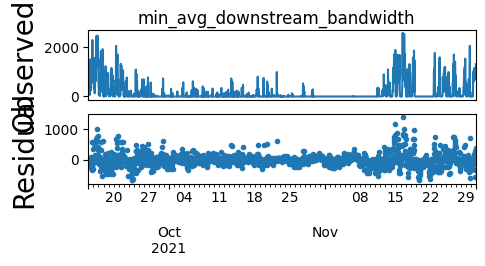

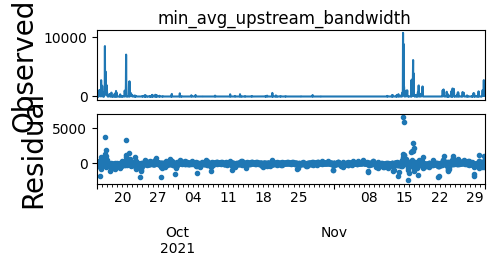

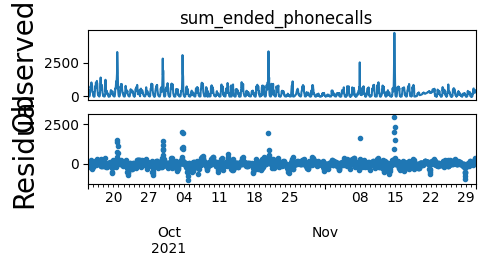

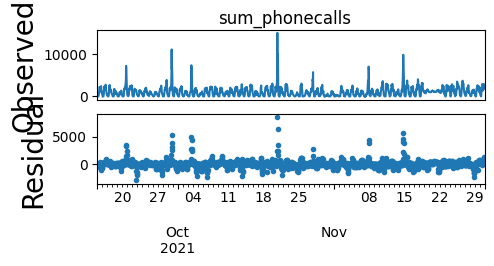

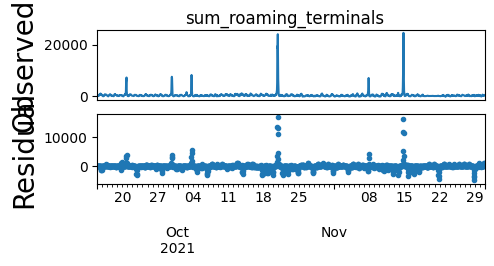

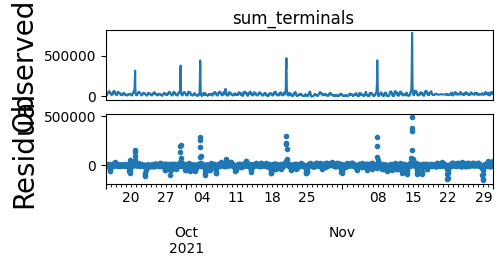

In [16]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = [3,4]
normalize = False
subsequence_lengths = [6, 12, 24]

resids = pd.read_csv(results_path + "/resids.csv", index_col=0)

# plot the data and residuals of top 3 taz_ids
top_taz_ids = stats_table["id"].head(1).values
# create dataframe with taz_id and resids
top_resids = pd.DataFrame()
for taz_id in top_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            hourly_taz_data[hourly_taz_data["taz_id"] == taz_id][
                [data_feature, "one_time"]
            ]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": resids[str(taz_id) + "_" + data_feature],
        }
        top_resids = pd.concat([top_resids, pd.DataFrame(row)], ignore_index=True)

# for (id, feature) get dataframe and plot observed and residuals
for i, df in top_resids.groupby(by=["id", "feature"]):
    # plot observed and residuals
    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df["observed"].values, index=df["index"])
    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.suptitle(i[1])

    plt.show()

for m in subsequence_lengths:
    X = []
    for i, df in top_resids.groupby(by=["id", "feature"]):
        X.append(df["residuals"].values)
    X = np.array(X)
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save(
        results_path
        + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_multivar.npy".format(
            normalize, top_k_mp, m, i[0]
        ),
        mp,
        allow_pickle=True,
    )
    np.save(
        results_path
        + "/mp_indices/hourly_taz_normalize={}_topkmp={}_m={}_{}_multivar.npy".format(
            normalize, top_k_mp, m, i[0]
        ),
        mp_indices,
        allow_pickle=True,
    )


In [17]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            current_data = data[dimensions]
            n_vars, n_time = current_data.shape

            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], current_data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [18]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = 1

# Initialize mp_stats_table outside the loop to accumulate results
mp_stats_table = pd.DataFrame()

for m in subsequence_lengths:
    X = []
    for i, df in top_resids.groupby(by=["id", "feature"]):
        print(i[0], taz_id_name[i[0]])
        X.append(df["residuals"].values)

    mp = np.load(
        results_path
        + "/mp/hourly_taz_normalize={}_topkmp={}_m={}_{}_multivar.npy".format(
            normalize, top_k_mp, m, i[0]
        ),
        allow_pickle=True,
    )
    indices = np.load(
        results_path
        + "/mp_indices/hourly_taz_normalize={}_topkmp={}_m={}_{}_multivar.npy".format(
            normalize, top_k_mp, m, i[0]
        ),
        allow_pickle=True,
    )
    X = np.array(X)
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(
        X,
        mp,
        indices,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoffs=cutoff,
        max_matches=max_matches,
        max_motifs=max_motifs,
        k=k,
        include=include,
        normalize=normalize,
    )
    if len(motif_indices[0]) == 0:
        continue

    # Create the table for the current iteration
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        motif_subspaces,
        X,
        k_distances,
        m,
        normalize,
        max_distance,
    )
    logging.info(
        "m:{}, #Motifs:{}, Sig:{}".format(
            m, len(motif_indices), np.sum(table["p-value"] < 0.001)
        )
    )

    # Apply Hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
    sig = (
        table["p-value"] < critical_value
        if critical_value != 0
        else table["p-value"] <= critical_value
    )
    table["Sig_Hochber"] = sig

    print(
        "Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value)
    )

    # Append the current table to mp_stats_table
    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

# Save the accumulated mp_stats_table to CSV
mp_stats_table.to_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
        normalize,
        min_neighbors,
        max_distance,
        cutoff,
        max_matches,
        max_motifs,
        i[0],
    ),
    index=False,
)

37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)


INFO:root:p_value = 7.686E-14 (p_pattern = 1.900E-06)
INFO:root:p_value = 5.660E-25 (p_pattern = 3.129E-09)
INFO:root:p_value = 4.176E-22 (p_pattern = 1.336E-06)
INFO:root:p_value = 6.277E-20 (p_pattern = 3.082E-06)
INFO:root:p_value = 8.220E-18 (p_pattern = 6.948E-06)
INFO:root:m:6, #Motifs:5, Sig:5


Sig after Hochberg: 4, critical value: 7.685646976018909e-14
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)


INFO:root:p_value = 5.218E-17 (p_pattern = 2.219E-08)
INFO:root:p_value = 2.807E-23 (p_pattern = 1.668E-08)
INFO:root:p_value = 1.746E-25 (p_pattern = 3.319E-11)
INFO:root:p_value = 6.797E-25 (p_pattern = 9.220E-07)
INFO:root:p_value = 3.471E-33 (p_pattern = 3.826E-08)
INFO:root:m:12, #Motifs:5, Sig:5


Sig after Hochberg: 4, critical value: 5.21834690064142e-17
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)
37 São Domingos de Benfica (Estrada Luz | Oeste)


INFO:root:p_value = 8.597E-28 (p_pattern = 1.137E-11)
INFO:root:p_value = 2.414E-41 (p_pattern = 3.382E-09)
INFO:root:p_value = 7.013E-44 (p_pattern = 1.278E-09)
INFO:root:m:24, #Motifs:3, Sig:3


Sig after Hochberg: 2, critical value: 8.597063151657533e-28


In [19]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

for i, df in top_resids.groupby(by=["id"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(
        columns=[
            "m",
            "#motifs",
            "avg_n_matches",
            "avg_n_features",
            "avg_probability",
            "avg_pvalue",
            "#sig_motifs(<0.01)",
            "significant",
            "#sig_hochberg",
        ]
    )
    for m in motif_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        if table.empty:
            continue
        n_motifs = table.shape[0]
        n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = (
            round(table["#Matches"].mean(), 2),
            round(table["#Matches"].std(), 3),
        )
        avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
        avg_probability = table["P"].mean(), table["P"].std()
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {
            "m": m,
            "#motifs": n_motifs,
            "#sig_motifs(<0.001)": n_sig_motifs_0001,
            "significant": (n_sig_motifs_0001 * 100) / n_motifs,
            "avg_n_matches": avg_n_matches,
            "avg_n_features": avg_n_features,
        }

        motif_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if motif_stats_table.empty
            else pd.concat(
                [motif_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

    print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

37 São Domingos de Benfica (Estrada Luz | Oeste)
\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
6 & 5 & 5 & 100.000 & (4.2, 1.095) & (2.0, 0.0) \\
12 & 5 & 5 & 100.000 & (3.4, 1.517) & (2.0, 0.0) \\
24 & 3 & 3 & 100.000 & (4.0, 1.732) & (2.0, 0.0) \\
\bottomrule
\end{tabular}



In [20]:
# get top 3 most significant for each motif length
for i, df in top_resids.groupby(by=["id"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            normalize,
            min_neighbors,
            max_distance,
            cutoff,
            max_matches,
            max_motifs,
            i[0],
        )
    )
    # excluded p-value > 0.001
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "k",
                "Features",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:6 #########
\begin{tabular}{rrrlrrrrrlr}
\toprule
ID & #Matches & k & Features & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
0 & 3 & 2 & 3,4 & 0.547 & 0.260 & 1690.907 & 892.954 & 1393.260 & 7.69e-14 & 3.570 \\
3 & 5 & 2 & 4,3 & 0.289 & 0.260 & 3501.086 & 1318.075 & 1814.034 & 6.28e-20 & 2.480 \\
4 & 5 & 2 & 3,4 & 0.447 & 0.220 & 15950.638 & 7458.762 & 13744.856 & 8.22e-18 & 7.230 \\
2 & 5 & 2 & 4,3 & 0.278 & 0.202 & 2454.587 & 1307.374 & 1851.509 & 4.18e-22 & 5.730 \\
1 & 3 & 2 & 4,3 & 0.473 & 0.201 & 1073.546 & 946.695 & 1030.983 & 5.66e-25 & 1.210 \\
\bottomrule
\end{tabular}



########## m:12 #########
\begin{tabular}{rrrlrrrrrlr}
\toprule
ID & #Matches & k & Features & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
1 & 3 & 2 & 4,3 & 0.260 & 0.236 & 3192.625 & 2017.003 & 2368.256 & 2.81e-

In [21]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name, save_path):
    # Set up the plot with 2 columns instead of 3
    fig, axes = plt.subplots(
        ncols=2, nrows=len(ts_list), figsize=(10, 3 * len(ts_list)), squeeze=False
    )
    
    for i in range(0, len(ts_list)):
        ts = ts_list[i]
        # plot light grey background of the residual time series
        axes[i, 1].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            
            # Plot the raw motif subsequence
            axes[i, 0].plot(subsequence_match.values)
            
            # Highlight the motif in the residual time series
            axes[i, 1].plot(subsequence_match, linewidth=2)

        if m <= 12:
            axes[i, 0].set_xticks(range(0, len(subsequence_match)))
            axes[i, 0].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
        else:
            axes[i, 0].set_xticks([0, 6, 12, 18, 23])
            axes[i, 0].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])

        # Format the x axis to show the time and rotate for better readability
        axes[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        
        # Add y-labels if there are multiple features (multivariate data)
        if len(ts_list) > 1:
            axes[i, 0].set_ylabel(features[i], rotation=90, size="large")

        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 1].xaxis.get_majorticklabels(), rotation=45)

    # Titles for the two plots
    axes[0, 0].set_title("Raw Subsequences")
    axes[0, 1].set_title("Motif in Residual TS")
    
    plt.tight_layout()
    plt.savefig(
        save_path + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None

INFO:root:########## taz_name: São Domingos de Benfica (Estrada Luz | Oeste) #########
INFO:root:Motif length: 6
INFO:root:Processing motif: {'ID': 0, 'k': 2, 'Features': '3,4', 'm': 6, '#Matches': 3, 'Indices': '[1626, 1794, 786, 954]', 'max(dists)': 1690.907, 'min(dists)': 892.954, 'med(dists)': 1393.26, 'CE': 0.547, 'Score Unified': 0.26, 'Explained Var(%)': 3.57, 'P': 1.9000275871327348e-06, 'p-value': 7.685646976018909e-14, 'Sig_Hochber': False}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 3, 'k': 2, 'Features': '4,3', 'm': 6, '#Matches': 5, 'Indices': '[1294, 356, 139, 451, 863, 1462]', 'max(dists)': 3501.086, 'min(dists)': 1318.075, 'med(dists)': 1814.034, 'CE': 0.289, 'Score Unified': 0.26, 'Explained Var(%)': 2.48, 'P': 3.0821875955915165e-06, 'p-value': 6.276963677903369e-20, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 4, 'k': 2, 'Features': '3,4', 'm': 6, '#Matches': 5, 'Indices': '[857, 1456, 447, 353, 136, 1292]', 'max(dists)': 15950.638, 'min(dists)': 7458.762, 'med(dists)': 13744.856, 'CE': 0.447, 'Score Unified': 0.22, 'Explained Var(%)': 7.23, 'P': 6.9480172210142445e-06, 'p-value': 8.220233931437443e-18, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 2, 'k': 2, 'Features': '4,3', 'm': 6, '#Matches': 5, 'Indices': '[134, 351, 444, 1453, 853, 1290]', 'max(dists)': 2454.587, 'min(dists)': 1307.374, 'med(dists)': 1851.509, 'CE': 0.278, 'Score Unified': 0.202, 'Explained Var(%)': 5.73, 'P': 1.3364644814991936e-06, 'p-value': 4.17575955012774e-22, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 1, 'k': 2, 'Features': '4,3', 'm': 6, '#Matches': 3, 'Indices': '[522, 786, 186, 882]', 'max(dists)': 1073.546, 'min(dists)': 946.695, 'med(dists)': 1030.983, 'CE': 0.473, 'Score Unified': 0.201, 'Explained Var(%)': 1.21, 'P': 3.1293157771953117e-09, 'p-value': 5.6603206807764655e-25, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Motif length: 12
INFO:root:Processing motif: {'ID': 1, 'k': 2, 'Features': '4,3', 'm': 12, '#Matches': 3, 'Indices': '[354, 137, 448, 1293]', 'max(dists)': 3192.625, 'min(dists)': 2017.003, 'med(dists)': 2368.256, 'CE': 0.26, 'Score Unified': 0.236, 'Explained Var(%)': 3.37, 'P': 1.6676349666509926e-08, 'p-value': 2.806882278978277e-23, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 0, 'k': 2, 'Features': '4,3', 'm': 12, '#Matches': 2, 'Indices': '[438, 344, 127]', 'max(dists)': 1417.622, 'min(dists)': 996.94, 'med(dists)': 1207.281, 'CE': 0.193, 'Score Unified': 0.17, 'Explained Var(%)': 3.11, 'P': 2.2190934128113927e-08, 'p-value': 5.2183469006414204e-17, 'Sig_Hochber': False}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 3, 'k': 2, 'Features': '3,4', 'm': 12, '#Matches': 5, 'Indices': '[848, 1448, 439, 344, 1283, 128]', 'max(dists)': 7776.936, 'min(dists)': 3251.94, 'med(dists)': 7229.555, 'CE': 0.228, 'Score Unified': 0.157, 'Explained Var(%)': 7.73, 'P': 9.219684165060974e-07, 'p-value': 6.79740675279579e-25, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 4, 'k': 2, 'Features': '3,4', 'm': 12, '#Matches': 5, 'Indices': '[859, 1458, 449, 355, 138, 1294]', 'max(dists)': 16042.283, 'min(dists)': 7513.521, 'med(dists)': 13996.238, 'CE': 0.24, 'Score Unified': 0.15, 'Explained Var(%)': 7.22, 'P': 3.8257796235770316e-08, 'p-value': 3.4710886995084656e-33, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 2, 'k': 2, 'Features': '3,4', 'm': 12, '#Matches': 2, 'Indices': '[1284, 128, 345]', 'max(dists)': 2740.054, 'min(dists)': 2585.25, 'med(dists)': 2662.652, 'CE': 0.241, 'Score Unified': 0.136, 'Explained Var(%)': 4.02, 'P': 3.318994820086566e-11, 'p-value': 1.745935161986732e-25, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Motif length: 24
INFO:root:Processing motif: {'ID': 0, 'k': 2, 'Features': '4,3', 'm': 24, '#Matches': 2, 'Indices': '[348, 131, 442]', 'max(dists)': 2498.865, 'min(dists)': 2136.973, 'med(dists)': 2317.919, 'CE': 0.184, 'Score Unified': 0.185, 'Explained Var(%)': 5.03, 'P': 1.136745212852063e-11, 'p-value': 8.597063151657533e-28, 'Sig_Hochber': False}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 2, 'k': 2, 'Features': '3,4', 'm': 24, '#Matches': 5, 'Indices': '[852, 1451, 442, 348, 131, 1287]', 'max(dists)': 16453.626, 'min(dists)': 7672.961, 'med(dists)': 14230.407, 'CE': 0.215, 'Score Unified': 0.146, 'Explained Var(%)': 12.12, 'P': 1.2775108390831374e-09, 'p-value': 7.013038195548134e-44, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


INFO:root:Processing motif: {'ID': 1, 'k': 2, 'Features': '3,4', 'm': 24, '#Matches': 5, 'Indices': '[839, 1438, 429, 335, 118, 1274]', 'max(dists)': 16119.483, 'min(dists)': 7561.782, 'med(dists)': 13854.877, 'CE': 0.187, 'Score Unified': 0.137, 'Explained Var(%)': 10.94, 'P': 3.381905439559774e-09, 'p-value': 2.41372222285868e-41, 'Sig_Hochber': True}


['sum_ended_phonecalls', 'min_avg_upstream_bandwidth']


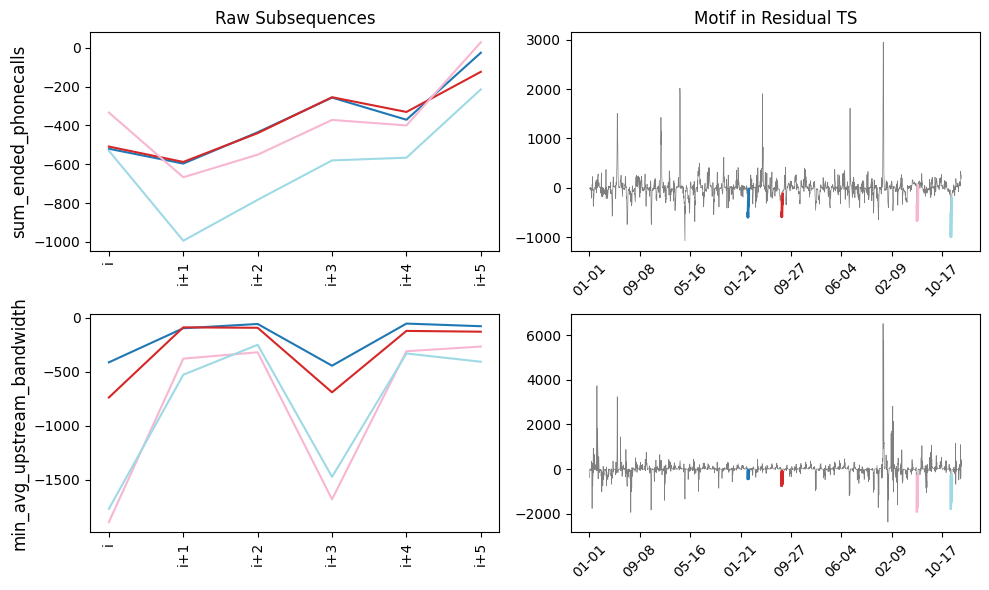

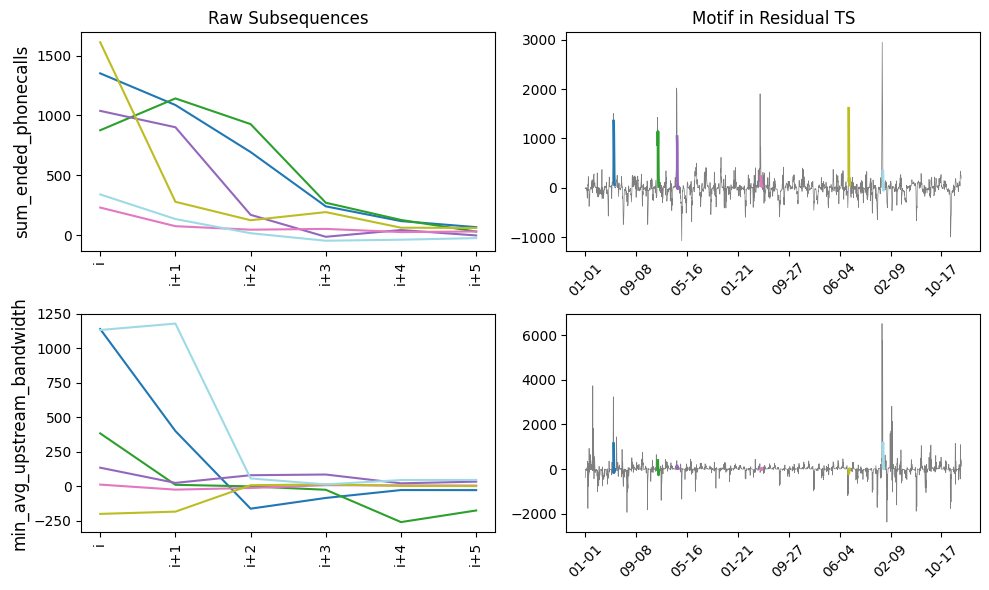

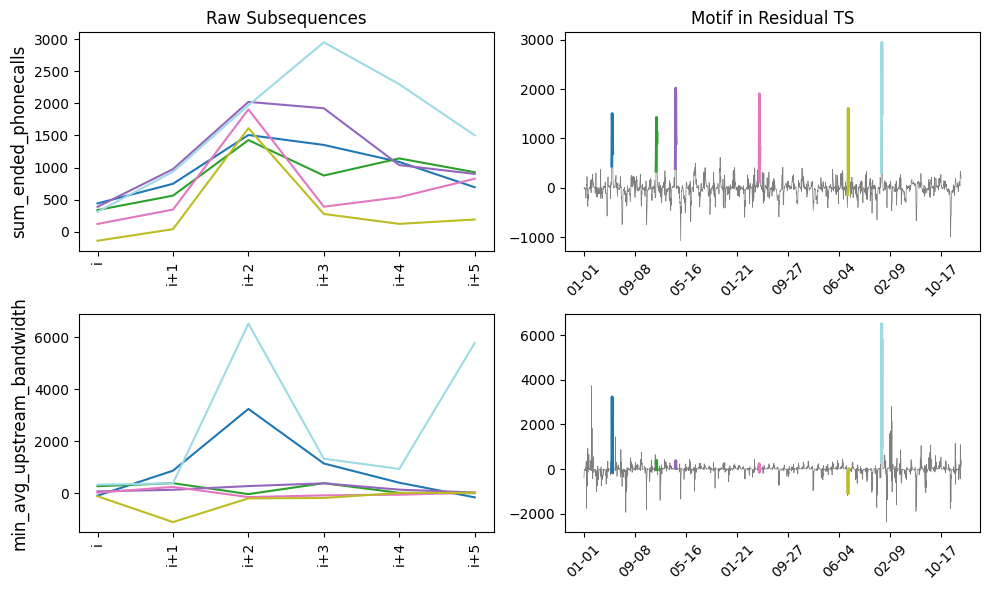

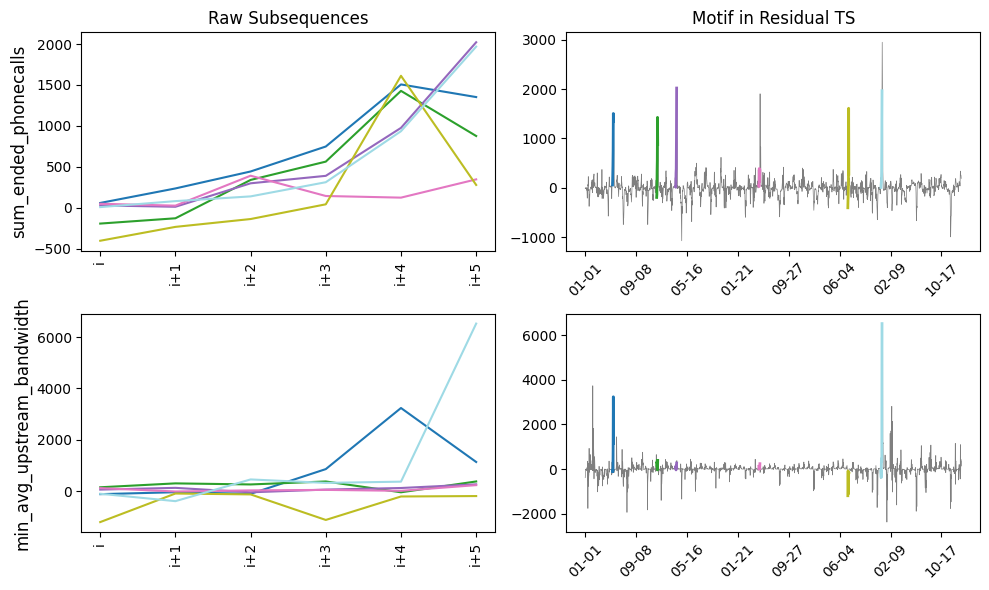

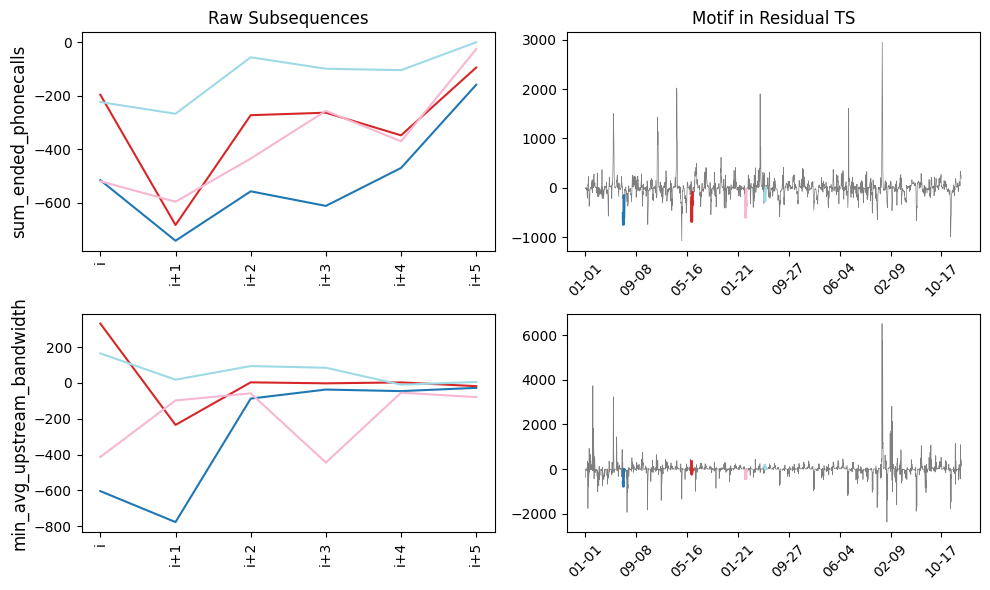

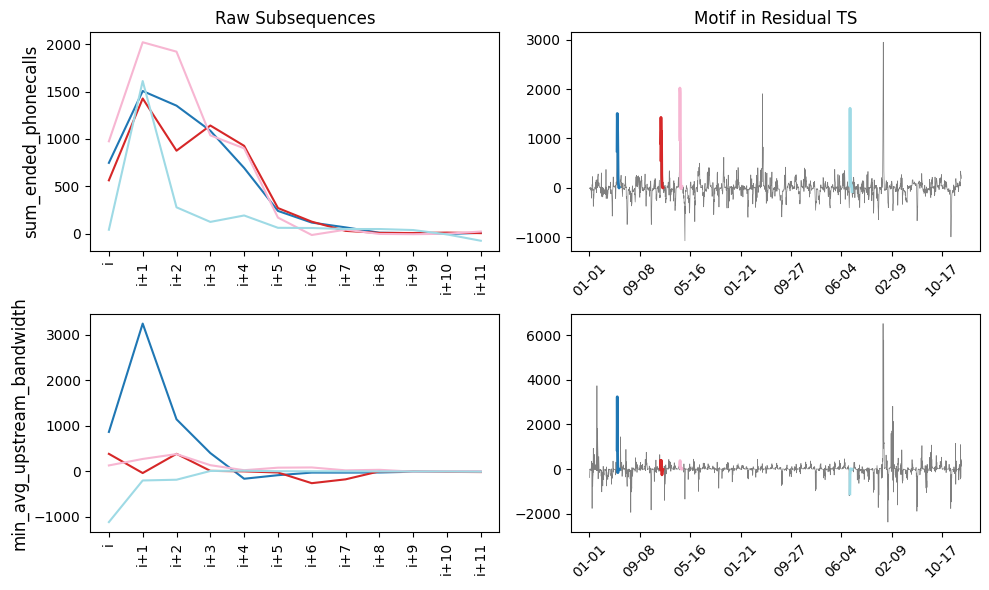

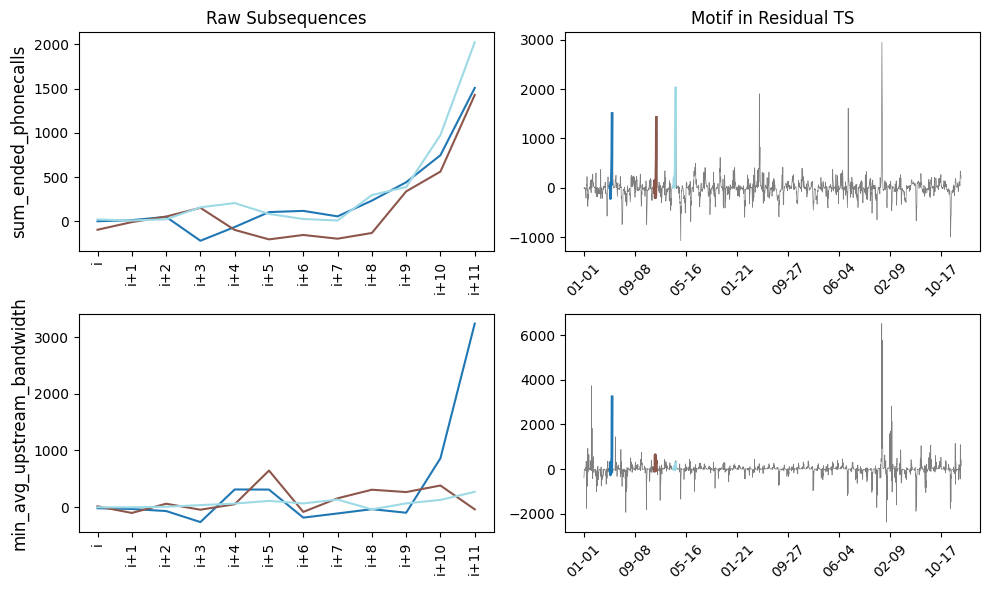

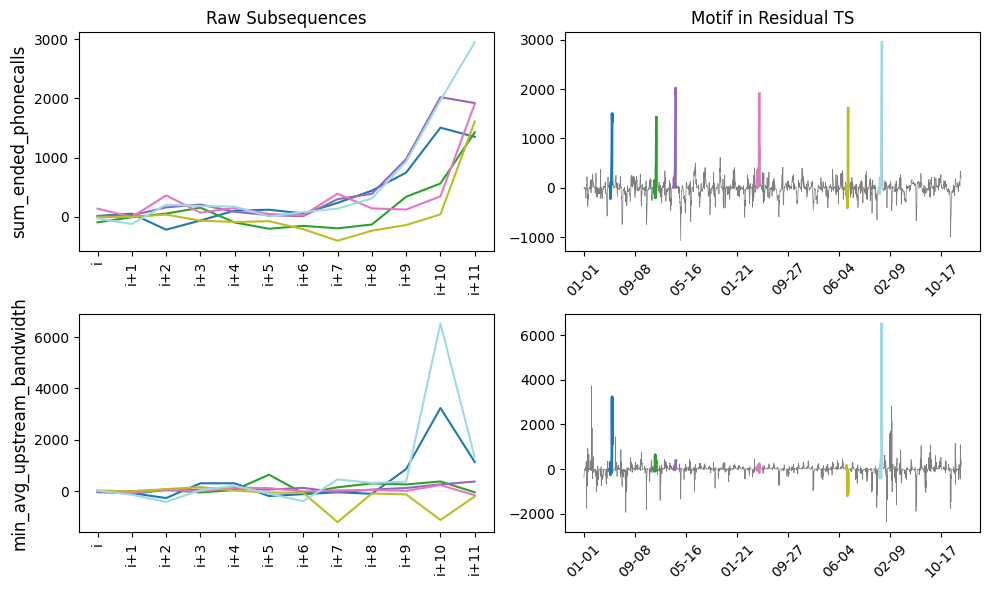

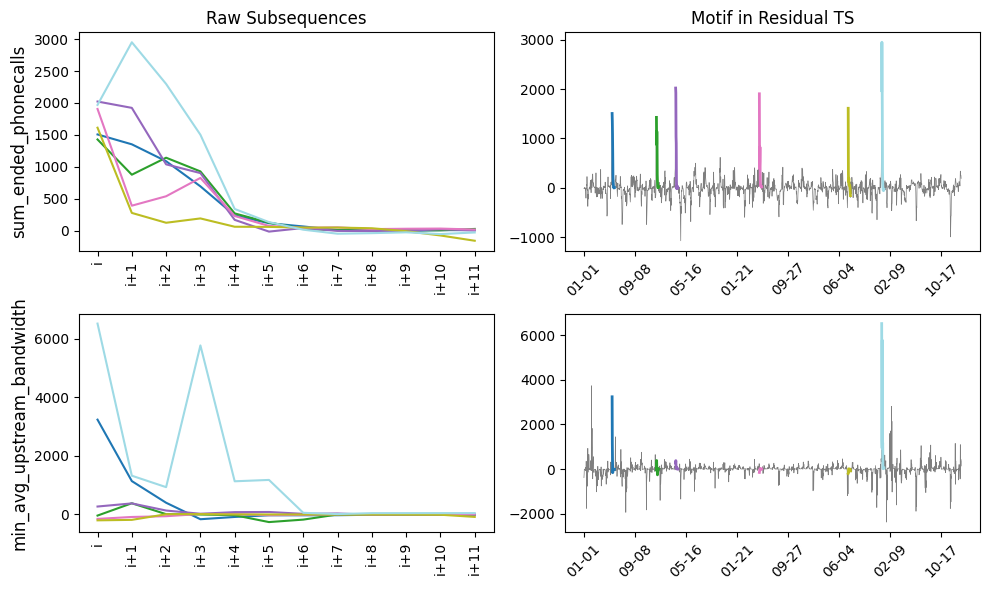

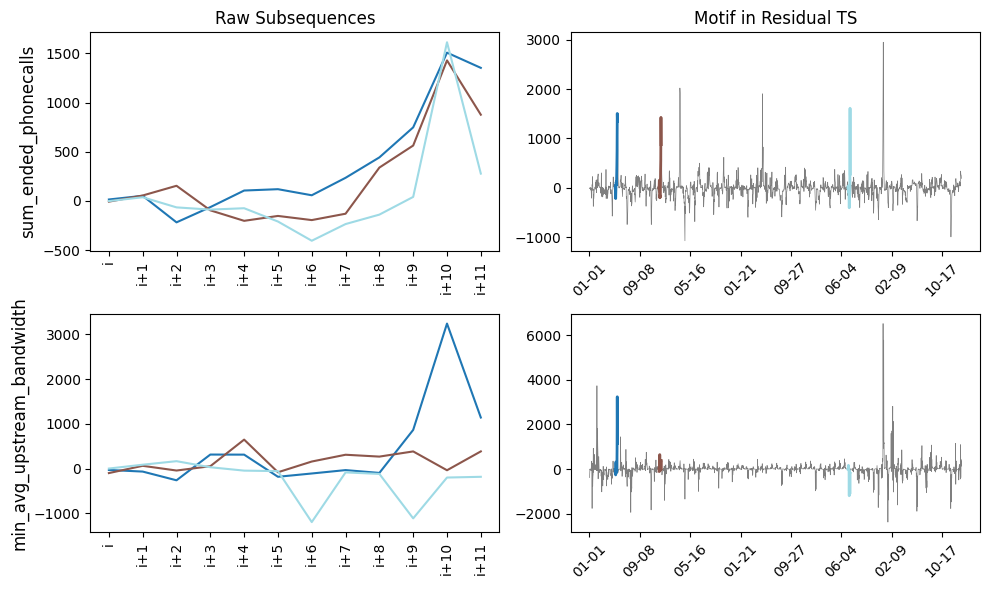

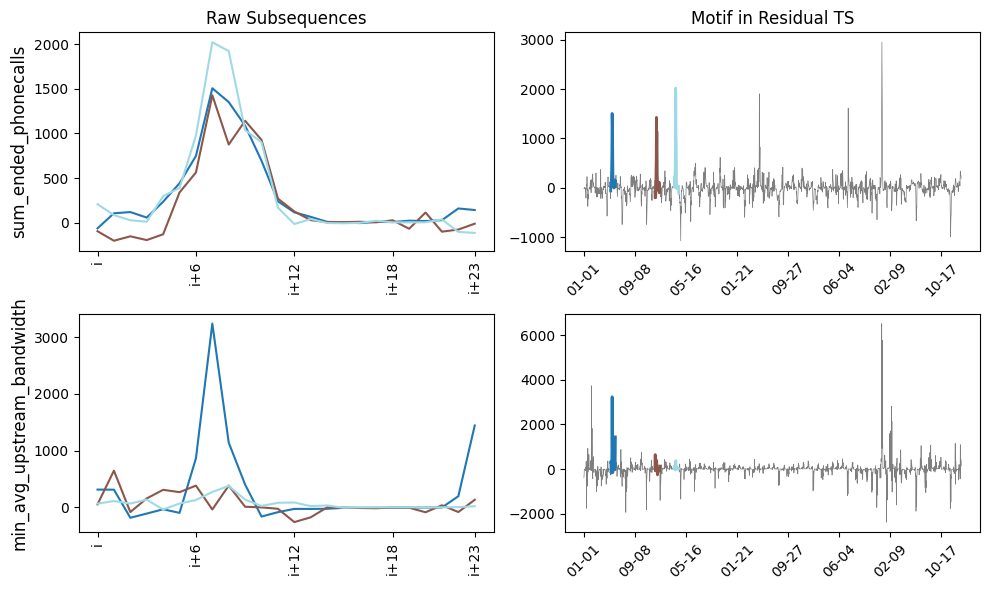

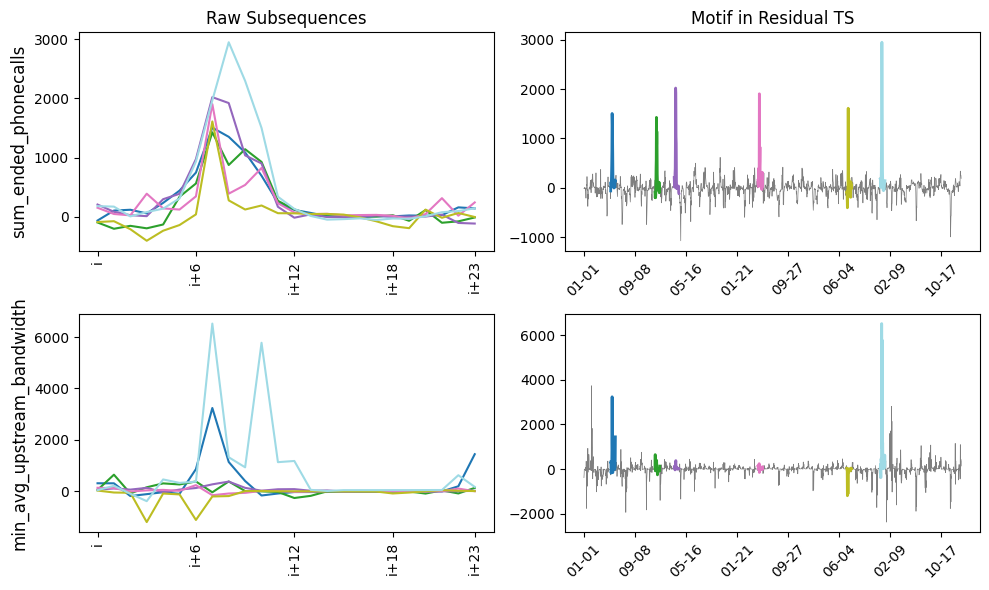

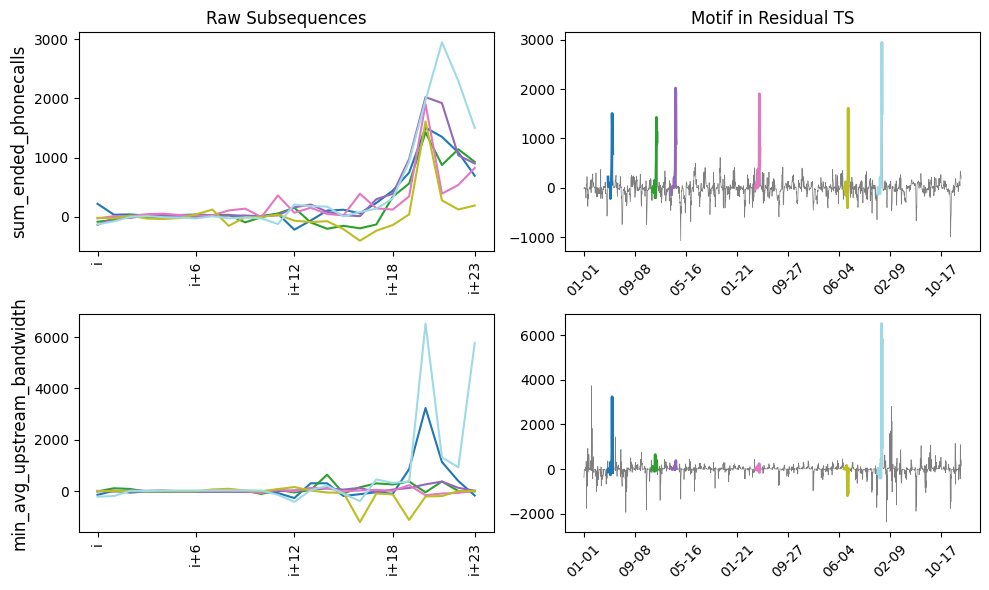

In [22]:
# Plot top motif
for i, df in top_resids.groupby(by=["id"]):
    taz_name = taz_id_name[i[0]]
    logging.info(f"########## taz_name: {taz_name} #########")

    # Create file path using os.path.join
    file_path = os.path.join(
        results_path,
        f"table_motifs_normalize={normalize}_min_neighbors={min_neighbors}_max_distance={max_distance}_cutoff={cutoff}_max_matches={max_matches}_max_motifs={max_motifs}_{i[0]}.csv",
    )
    mp_stats_table = pd.read_csv(file_path)

    save_path = os.path.join(results_path, taz_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Set datetime index
    df.index = pd.to_datetime(df["index"])

    # Group residuals by feature
    ts_dict = {
        feature: group.reset_index(drop=True)
        for feature, group in df.groupby("feature")["residuals"]
    }

    for m in mp_stats_table["m"].unique():
        logging.info(f"Motif length: {m}")
        top_motifs = mp_stats_table[mp_stats_table["m"] == m].sort_values(
            by="Score Unified", ascending=False
        )

        for top_motif in top_motifs.to_dict(orient="records"):
            logging.info(f"Processing motif: {top_motif}")

            # Parse features and indices
            dimensions = sorted(map(int, top_motif["Features"].split(",")))
            used_features = [features[index] for index in dimensions]
            indices = list(map(int, top_motif["Indices"].strip("[]").split(",")))
            # filter just 10 first indices
            indices = sorted(indices)

            if dimensions in [
                [0, 1],
                [2, 3],
                [4, 5],
            ]:  # Skip if features are in excluded combinations
                continue

            motif_name = f"{i[0]}_{top_motif['ID']}"

            # Extract the time series for relevant features
            ts_list = [ts_dict[feature] for feature in used_features]
            print(used_features)

            # Plot the motifs
            plot_motif(ts_list, used_features, m, indices, motif_name, save_path)